# Time Domain Tutorial #1
## State Space Oscillators: Spectral Decomposition

NESS 2023

Emily Stephen, adapted from Alex He's `somata/Examples/IterOsc_example.py`

In this tutorial, we will use the SSO framework for spectral decomposition, using the iterative oscillator decomposition algorithm<sup>1</sup>.




[1] Beck, A. M., He, M., Gutierrez, R. G., & Purdon, P. L. (2022). An iterative search algorithm to identify oscillatory dynamics in neurophysiological time series. bioRxiv, 2022-10. [10.1101/2022.10.30.514422](https://doi.org/10.1101/2022.10.30.514422)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from somata.iterative_oscillator import IterativeOscillatorModel as IterOsc
from somata.iterative_oscillator.helper_functions import simulate_matsuda, sim_to_osc_object

### Simulate a SSO with two oscillations, 2Hz and 10Hz

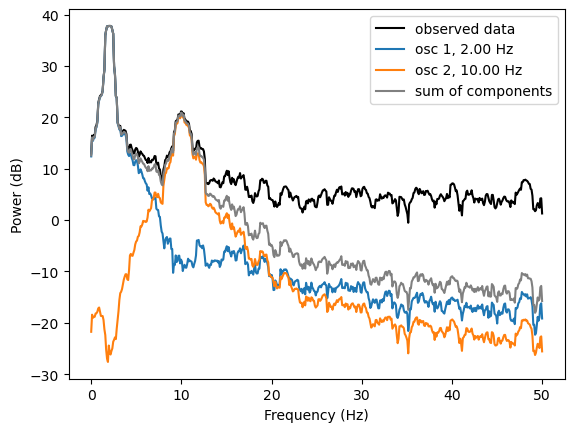

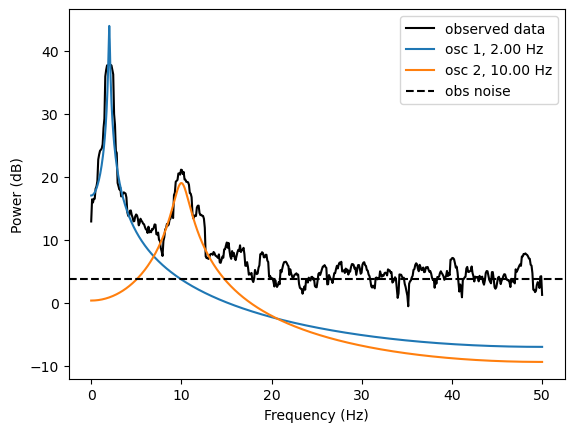

In [2]:
fs = 100  # sampling frequency (Hz)
noise_start = 30
osc1 = {'a': 0.996, 'q': 0.4, 'f': 2}  # set simulating parameters for slow oscillation
osc2 = {'a': 0.95, 'q': 0.2, 'f': 10}  # set simulating parameters for alpha oscillation
y, param_list, ob_noise = simulate_matsuda([osc1, osc2], R=1.2, Fs=fs, T=10)
sim_osc0, sim_x0 = sim_to_osc_object(y, param_list)  # save simulations as Osc object to pass into plotting functions

_ = sim_osc0.visualize_freq('actual')
_ = sim_osc0.visualize_freq('theoretical')

### Run the iterative oscillator decomposition algorithm and plot the results

In [3]:
# Initialize Iterative Oscillator object
io_orig = IterOsc(y, fs, noise_start, ar_order=13, burg_flag=False, verbose=False)  # ar_order and burg_flag are set as
# defaults. ar_order is the order of the AR model fit to the innovations. Set burg_flag to True to use the Burg
# algorithm to fit the AR model to innovations instead of the default Yule-Walker algorithm.

# Run through iterations to fit model
io_orig.iterate(osc_range=7, plot_innov=False, verbose=False)
# osc_range is maximum number of total oscillators, set to default.
# plot_innov=True plots innovation spectrum and AR fitting during iterations
# verbose=True prints parameters throughout the method

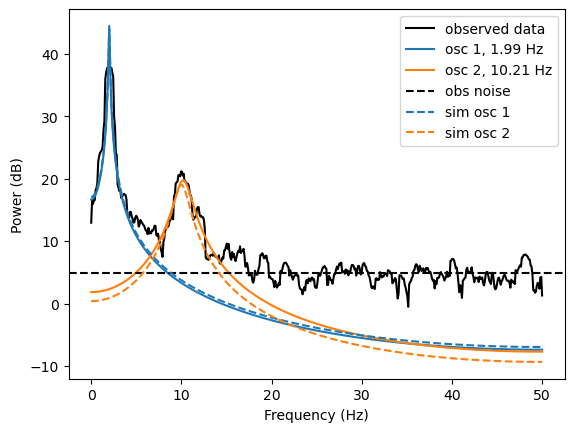

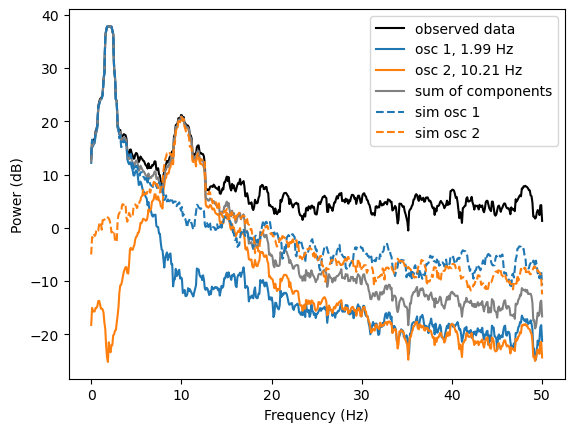

In [4]:
# Plot frequency domain (from parameters and from estimated x_t)
best_io = io_orig.scaled_osc[io_orig.knee_index]
for version in ['theoretical', 'actual']:
    _ = best_io.visualize_freq(version, y=io_orig.y_original, sim_osc=sim_osc0,
                                                              sim_x=sim_x0)

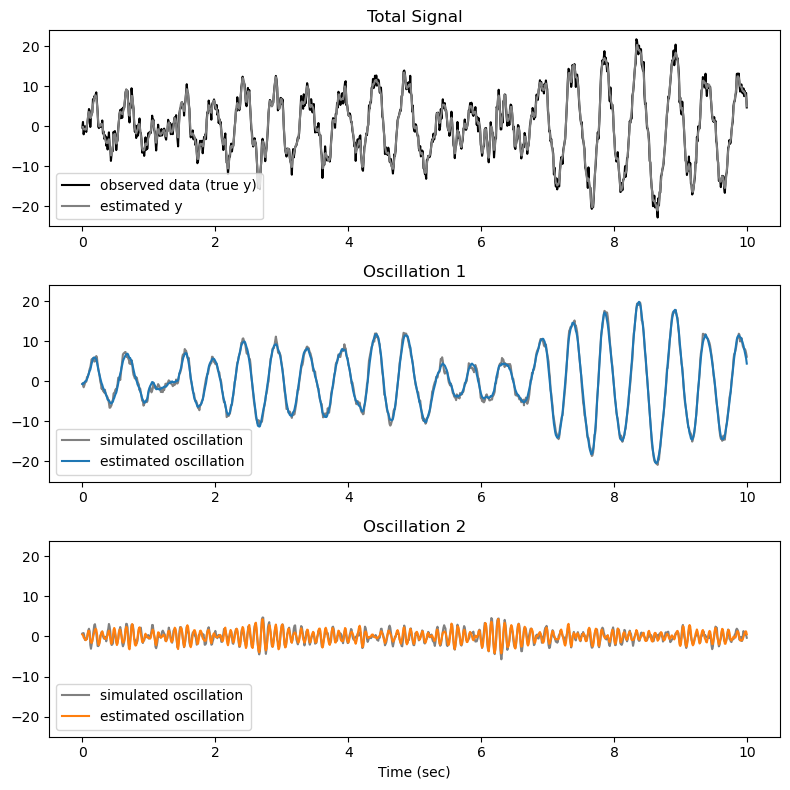

In [5]:
# Plot time domain estimated x_t
_ = best_io.visualize_time(y=io_orig.y_original, sim_x=sim_x0)

Text(0.5, 1.0, 'Log Likelihood')

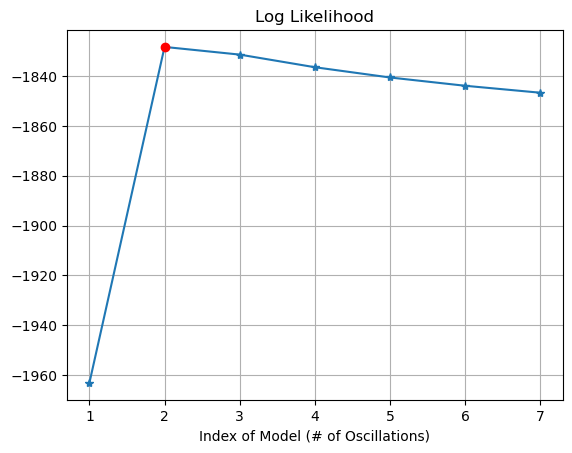

In [6]:
# Plot likelihood and selected model (may not be the highest likelihood)
plt.figure()
plt.plot(range(1, len(io_orig.scaled_osc) + 1), io_orig.ll, '-*', label='__nolegend__')
plt.scatter(io_orig.knee_index + 1, io_orig.ll[io_orig.knee_index], color='red', zorder=2,
            label='model selected with knee')
plt.xlabel('Index of Model (# of Oscillations)')
plt.grid('on')
plt.title('Log Likelihood')

### Plot details about the alpha oscillator, with instantaneous phase and amplitude

(0.0, 3.0)

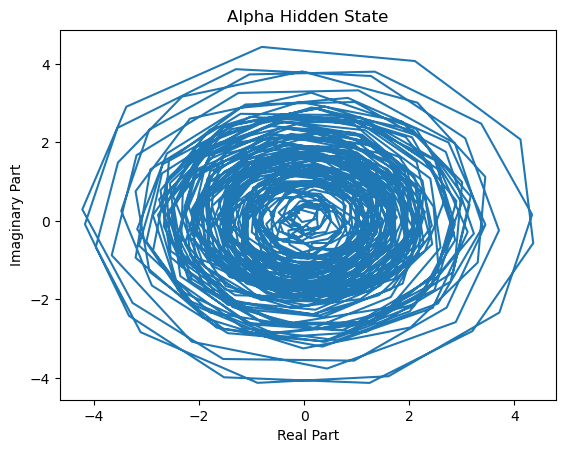

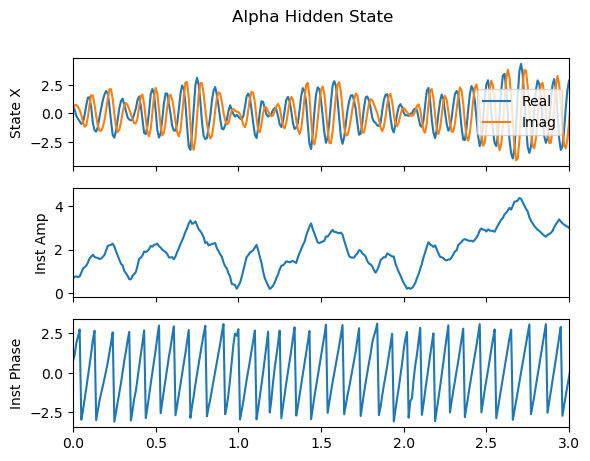

In [7]:
# Plot the hidden state, instantaneous amplitude and phase for the 10hz oscillator
kalman_out = best_io.kalman_filt_smooth(y=io_orig.y_original,return_dict=True)
x_alpha = kalman_out['x_t_n'][2:4, 1:] # drop the first time index
ta = np.arange(x_alpha.shape[1]) / best_io.Fs

# Compute instantaneous amplitude and phase
from math import atan2
alpha_phase = np.array([atan2(x_alpha[1,i],x_alpha[0,i]) for i in range(len(ta))])
alpha_amp = np.sqrt(x_alpha[0,:]**2 + x_alpha[1,:]**2)

plt.figure()
plt.plot(x_alpha[0],x_alpha[1])
plt.title('Alpha Hidden State')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')

[fig,axs] = plt.subplots(3,1,sharex=True)
fig.suptitle('Alpha Hidden State')
axs[0].plot(ta,x_alpha.T)
axs[0].legend(['Real','Imag'])
axs[0].set_ylabel('State X')
axs[1].plot(ta,alpha_amp)
axs[1].set_ylabel('Inst Amp')
axs[2].plot(ta,alpha_phase)
axs[2].set_ylabel('Inst Phase')
axs[0].set_xlim([0,3])